# NeuralNorns

Welcome to the NeuralNorns! NeuralNorns is a machine learning model designed for creating repeating patterns, such as drum beats or arpeggios. The model is based on the autoencoder architecture and can be easily exported to run in P5.js applications, or on the Norns platform.

In this tutorial, you will be guided through the following steps:

1.   **Data Collection:** Learn how to gather and preprocess the training data to ensure the best results for your patterns.
2.   **Model Training:** Understand how to train the NeuralNorns model effectively.
3.   **Model Export:** Explore the process of exporting the trained model to different platforms for practical applications.

By the end of this tutorial, you'll have the knowledge and tools to create your own mesmerizing repeating patterns with NeuralNorns. Let's get started!

## Step 0: Includes and Helper Functions

Before we begin, we must include essential Python libraries and define some custom helper functions.

**Click** on the **play button** located in the upper left corner of the code cell below.

During execution, you may notice an "is processing" animation around the play button. The time taken for execution depends on the complexity of the cell.

Once the cell is fully executed, a green tick will appear along with the execution time.

Console logs are provided under each cell for a better understanding of the process.

In [ ]:
# HELPER FUNCTIONS & LIBRARIES

from google.colab import files
import io
import json
import time as time

import itertools
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# converts nested list into nested tuples
def to_tuple(lst):
  return tuple(to_tuple(i) if isinstance(i, list) else i for i in lst)

# converts nested list into set of nested tuples
def to_tuple_set(lst):
  s = set()
  s.update(to_tuple(lst))
  return s

# converts nested tuples into nested lists
def to_list(tpl):
  return list(to_list(i) if isinstance(i, tuple) else i for i in tpl)

print("great! you executed your first code block!")

great! you executed your first code block!


## Step 1: Data Collection
To start collecting data for training the machine learning model, follow these steps:

Click on the following link: [Data Collector](https://neuralnorns.medien.ifi.lmu.de/data_collector/). This will open a P5.js script that enables you to manually enter patterns, such as drum beats.
As you enter unique patterns, they will be automatically stored in the background.

To download the collected beats, press the **download** button on the web UI.
The downloaded file will be named **data_set.json**.

**The size of your data set significantly impacts the quality and performance of your machine learning model. Generally, having a set of 200 to 400 samples is considered sufficient for basic applications.**

Next, let's proceed to use the collected data for training the machine learning model. To do this:

1.   Execute the next cell by clicking on the play button located in the top left corner (*visible on hover*).
2.   Click on **choose files** to upload the trainingsdata. Navigate to your downloads folder and select the **data_set.json** file for uploading.

With the data now available, we can move on to the next step and train the machine learning model.

In [ ]:
# UPLOAD data_set.json

uploaded = files.upload()

Saving data_set_4.json to data_set_4.json


## Step 2: Data Cleaning and Adding Variations
Before we proceed with training the ML model, we need to prepare the data_set. The next cells will perform the following tasks:

1. **Data Extraction:** The pattern raw_data will be extracted from the uploaded file, and a separate variation data object will be created. **This step is mandatory** to structure the data for training.

2. **Creating Variations:** We will generate various pattern variations based on the provided patterns. These variations will involve muting active steps, permutating rows, choke rows, enforcing certain steps, and more. This step will enrich the data and enhance the model's ability to generalize.

For your initial experiments, start by using the raw data without applying any variation steps. This approach will provide a baseline for the model's performance and give us a sense of how well it can learn from the original data.

In [ ]:
# (1) EXTRACT DATA FROM JSON OBJECT AND CREATE VARIATION SET (MANDATORY)

last_upload = list(uploaded.keys())[0]
wrapper = io.TextIOWrapper(io.BytesIO(uploaded[last_upload]), encoding='utf-8')
raw_data_str = wrapper.read() # FILE AS STRING
data_set = json.loads(raw_data_str) # STRING TO JSON OBJECT

width = data_set["w"]
height = data_set["h"]
raw_data = set() # a set can only contain elements that are not equal, e.g. tuples => only unique tuples

for d in data_set["data"]:
  raw_data.add(to_tuple(d["data"]))

print("raw data: "+str(len(raw_data)))

# read from raw
variations = set()
for d in raw_data:
  variations.add(d)
print("variations:", len(variations))


raw data: 1001
variations: 1001


In [ ]:
# CREATE VARIATIONS BASED ON CARTESIAN PRODUCT (OPTIONAL)

# find all patterns for each row
patterns = [set() for i in range(height)]
for v in variations:
  for i in range(height):
    patterns[i].add(v[i])

# recombine all patterns via cartesian product
comb = itertools.product(*patterns)
variations = set()
for el in comb:
  variations.add(el)
print("variations:",len(variations))

variations: 609444


In [ ]:
# CHOKE GROUPS (OPTIONAL)

choke_groups = [(3,2)]

variations = to_list(variations)
for v in variations:
  for gr in choke_groups:
    lead = to_list(v[gr[0]])
    follow = to_list(v[gr[1]])
    v[gr[1]] = [1 if (f==1 and l!=f) else 0 for l, f in zip(lead, follow)]
variations = to_tuple_set(variations)

print("variations:",len(variations))

variations: 361152


In [ ]:
# ENFORCE BEATS (OPTIONAL)

enforced_patterns = [((1,0,0,0,0,0,0,0),(0,0,0,0,0,0,0,0),(0,0,0,0,0,0,0,0),(0,0,0,0,0,0,0,0))]

print(enforced_patterns[0][0][0])

variations = to_list(variations)
var = []
for v in variations:
  for pattern in enforced_patterns:
    lead = np.array(to_list(pattern)).flatten()
    follow = np.array(to_list(v)).flatten()
    flag = True
    for l, f in zip(lead, follow):
      if l==1 and f==0:
        flag = False
    if flag:
      var.append(v)
variations = to_tuple_set(var)

print("variations:",len(variations))

1
variations: 23252


In [ ]:
# REDUCE SIZE (OPTIONAL)

factor = 0.05
var = []

for el in variations:
  if random.random()<factor:
    var.append(to_list(el))

variations = to_tuple_set(var)
print("variations:",len(variations))


variations: 4587


In [ ]:
# PERMUTATE ACTIVE STEPS (OPTIONAL)

def permute_triggers (d,ox,oy,_set):
  h = len(d)
  w = len(d[0])
  for y in range(oy,h):
    for x in range(ox,w):
      if (d[y][x]) == 1:
        n = to_list(d)
        n[y][x] = 0
        n = to_tuple(n)
        _set.add(n)
        permute_triggers(n,x,y,_set)

# BIT PERMUTATIONS
var = set()
for d in variations:
  permute_triggers(d,0,0,var)
variations = variations | var

print("variations:",len(variations))

variations: 46504


## Step 3: Prepare Data for Training
Before we can use the data with the machine learning model, we need to transform it into a format compatible with TensorFlow. The following steps will be performed:

1. **Data Conversion:** We will convert the data into numpy arrays, a format that TensorFlow can work with efficiently.

2. **Randomization and Noise Addition:** To enhance the model's ability to generalize and avoid overfitting, we will randomize the order of elements inside the arrays. Additionally, we will introduce noise to the training data, which can be adjusted as needed.

By converting the data into numpy arrays and adding randomization and noise, we ensure that the model is exposed to a diverse and robust set of patterns during training.

In [ ]:
# (1) CONVERT VARIATIONS TO NUMPY ARRAY FOR ML

# flatten data to 1D
data = np.array([sum(to_list(v),[]) for v in variations])
print("data:",len(data))

data: 1001


In [ ]:
# (2) RANDOMIZE ORDER AND ADD NOISE

# RANDOMIZE ORDER
np.random.shuffle(data)
print("data: "+str(len(data)))

# ADD NOISE
noise_factor = 0.0
data_noisy = data + noise_factor * tf.random.normal(shape=data.shape)
data_noisy = tf.clip_by_value(data_noisy, clip_value_min=0., clip_value_max=1.)

data: 1001


## Step 4: Training
In this step, we will perform the following tasks:

1. **Define ML Architecture & Training:** We will define the architecture of the autoencoder, which will be used for training. The autoencoder is a neural network designed to learn efficient representations of the input data. We will run the training process using the defined architecture and the prepared data. The model will learn to generate repeating patterns based on the given data.

2. **Plotting History:** After training is complete, we will plot the training history.

3. **Plotting Predictions:** And visualize the model's predictions to evaluate its performance.

This step is crucial in creating a model capable of generating repeating patterns effectively.

Experimenting with different variations of the model architecture and training parameters can significantly impact the performance and output of the model.

### Tipps:

As of now, **only Sequential architectures that exclusively use dense layers are supported for export**. Additionally, to ensure proper recognition and functioning of the exported model in applications, it is crucial to name the two layers that form the output of the encoder and the input of the decoder as **latent** and **decoder**, respectively.

In order to normalize the vector dimensions to values between 0 and 1, it is essential to utilize the **sigmoid** activation function for both the output layer of the encoder and the output layer of the decoder in the model.

In [ ]:
# (1) ML MODEL ARCHITECTURE

latent_dim = 2
hidden_dim = 64
output_dim = width*height

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(hidden_dim, activation='relu'))
model.add(tf.keras.layers.Dense(hidden_dim, activation='relu'))
model.add(tf.keras.layers.Dense(latent_dim, activation='sigmoid', name="latent"))
model.add(tf.keras.layers.Dense(hidden_dim, activation='relu', name="decoder"))
model.add(tf.keras.layers.Dense(hidden_dim, activation='relu'))
model.add(tf.keras.layers.Dense(output_dim, activation='sigmoid'))

model.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])

history = model.fit(data_noisy, data,validation_split = 0.5, epochs=500, batch_size=4)

Epoch 1/500
125/125 [==============================] - 3s 7ms/step - loss: 0.1730 - accuracy: 0.8460 - val_loss: 0.1298 - val_accuracy: 1.0000
Epoch 2/500
125/125 [==============================] - 1s 5ms/step - loss: 0.1328 - accuracy: 1.0000 - val_loss: 0.1293 - val_accuracy: 1.0000
Epoch 3/500
125/125 [==============================] - 0s 4ms/step - loss: 0.1326 - accuracy: 1.0000 - val_loss: 0.1289 - val_accuracy: 1.0000
Epoch 4/500
125/125 [==============================] - 0s 4ms/step - loss: 0.1323 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 1.0000
Epoch 5/500
125/125 [==============================] - 1s 5ms/step - loss: 0.1322 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 1.0000
Epoch 6/500
125/125 [==============================] - 0s 4ms/step - loss: 0.1322 - accuracy: 1.0000 - val_loss: 0.1289 - val_accuracy: 1.0000
Epoch 7/500
125/125 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 1.0000 - val_loss: 0.1287 - val_accuracy: 1.0000

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


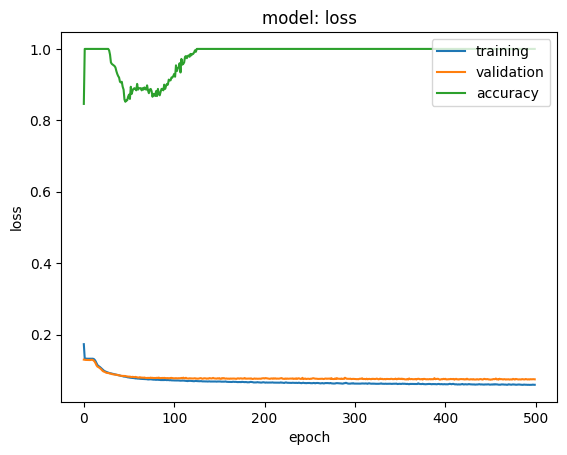

In [ ]:
# PLOT TRAINING HISTORY

print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.title('model: loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'accuracy'], loc='upper right')
plt.show()

32/32 [==============================] - 0s 2ms/step


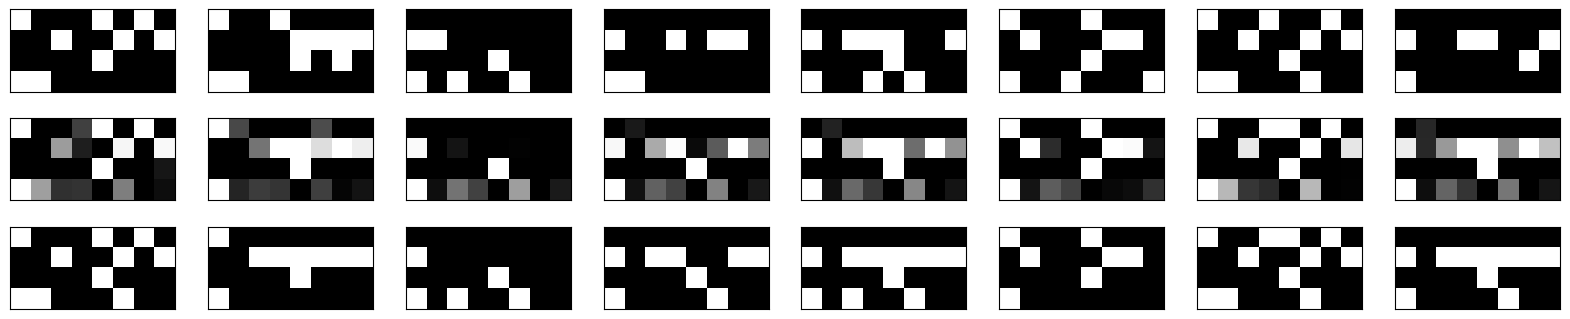

In [ ]:
# (3) PLOT MODEL PREDICTIONS

decoded_imgs = model.predict(data)

plt.figure(figsize=(20, 4))

n = 8
for i in range(n):
  # display original
  ax = plt.subplot(3, n, i + 1 + 0*n)
  img = data[i].reshape(height,width)
  img = np.flipud(img)
  plt.imshow(img)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display output vector
  ax = plt.subplot(3, n, i + 1 + 1*n)
  a = decoded_imgs[i].reshape(height,width)
  a = np.flipud(a)
  plt.imshow(a)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display output vector + threshold
  ax = plt.subplot(3, n, i + 1 + 2*n)
  b = np.where(a>0.4,1,0)
  plt.imshow(b)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## Step 5: Export
Congratulations on training your model! Now that the model is ready, you can proceed with exporting it for further use in various applications. Here's how you can do it:

1. **Export as JSON:** Save the trained model as a JSON file. This file can be utilized in a P5.js test application or in a Norns script, allowing you to generate repeating patterns in those environments.

2. Click on the **files** tab located on the left-hand side of the Colab interface. This will open a file explorer where you can manage your files.

3. Locate the file named model.json, which represents your trained model. It is stored in the **content** folder.

4. Right-click on the **model.json** file and select "Download" from the context menu.

By downloading the model.json file, you ensure that your trained model is securely saved and can be accessed for future use or further experimentation.

In [ ]:
# (1) EXPORT MODEL AS JSON FILE

json_obj = json.loads(model.to_json())

json_obj["width"] = width
json_obj["height"] = height

for layer in json_obj["config"]["layers"]:
  try:
    layer["weights"] = model.get_layer(layer["config"]["name"]).get_weights()[0].tolist()
    layer["bias"] = model.get_layer(layer["config"]["name"]).get_weights()[1].tolist()
  except:
    pass

with open('model.json', 'w', encoding='utf-8') as f:
    json.dump(json_obj, f, ensure_ascii=False, indent=2)

# Step 6: test model

The following P5 script allows you to test your trained model. Simply open the [ModelReader](https://neuralnorns.medien.ifi.lmu.de/model_reader/) and drag and drop the **model.json** file.